# Apply Trained Model on All Images and Collect Measurements

This notebook applies pre-trained model from the [previous notebook](2_Train_Pixel_Classifier.ipynb) to all images of a `Patient_X` in the `Spheroids` folder and save tables with measurements.

It also builds a master table with all measurements from all images in a single table, and provide optional plots.

## Import libraries

In [1]:
from pathlib import Path
from skimage.io import imread, imsave
import napari_simpleitk_image_processing as nsitk
import numpy as np
import apoc
from napari_skimage_regionprops import regionprops_table
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

from utilities import refine_labels

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='skimage') # Ignore low resolution image warnings

%load_ext watermark

## 1. Inputs

Folder to images and number of images in training and validation sets

In [2]:
data_path =  Path("../../data/Spheroids/Patient_1")

# Load min_area json file, get min_area key-value par and store it in min_area variable
# print message if file is not found
try:
    with open(data_path / 'min_area.json') as f:
        min_area = json.load(f)['min_area']
# Handle exception in case file is not found
except FileNotFoundError:
    print(f"Warning! 'min_area.json' file not found in {data_path}! Using default value of 1000.")
    min_area = 1000

print(f"min_area = ", min_area)

min_area =  1000


Get list of all images in the folder (except for those in `train`, `validation`, `train_annotations` or `control` folders) and store them in a list.

In [3]:
image_path_list = []
# Iterate over all paths inside folder path
for path in data_path.rglob("*"):
     # Check if path is a .tif file
    if (path.is_file() and path.suffix == '.tif'):
         # check if file path does not include 'train', 'validation', 'train_annotations' or 'control' folder
        if ('train' not in path.parts) and ('validation' not in path.parts) and ('Outputs' not in path.parts) and ('train_annotations' not in path.parts):
            image_path_list.append(path)

Load pre-trained model from the previous notebook.

In [4]:
model_path = data_path / 'my_model.cl'

## 2. Define workflow to run model and post-processing functions in a single function

In [5]:
def workflow(image_path, model_path, min_area):
    image = imread(image_path)
    model = apoc.PixelClassifier(opencl_filename=model_path)

    # Provide standard deviation filter as extra channel
    extra_channel = nsitk.laplacian_of_gaussian_filter(image, 1.0)
    extra_channel = nsitk.standard_deviation_filter(extra_channel, 1, 1, 0)
    image_stack = np.stack([image, extra_channel])

    # Get model prediction
    prediction = model.predict(image=image_stack)

    # Instance Segmentation and Post-process labels
    labels_post_processed = refine_labels(prediction, min_area)
    
    # Get size measurements
    table = regionprops_table(
        image,
        labels_post_processed,
        size=True,
        shape=True,
        intensity=False,
        napari_viewer=None,
    )
    
    return labels_post_processed, table

## 3. Batch Processing
For each path in the list, read the image, apply the workflow and save the results in an `Output` folder.

Labeled images and tables are saved inside the `Output` folder with the same name as the original image + "\_labels" or "\_table", respectively.

Measure features and save them in a table for each image. Concatenate all tables into a single master table.


In [6]:
master_df = pd.DataFrame()
# iterate over list of paths
for image_path in image_path_list:
    # applies workflow on image
    label_image, table = workflow(image_path, model_path, min_area)
    # Create an empty "Outputs" folder (if not there already)
    output_folder_path = Path(image_path.parent, 'Outputs')

    output_folder_path.mkdir(exist_ok = True)
    
    # Create a "image_labels.tif" path
    output_label_image_path = Path(output_folder_path, image_path.stem + '_labels.tif')
    # Store the label_image in the created "image_labels.tif" path
    imsave(output_label_image_path, label_image)
    
    # Create a "image_table.csv" path
    output_table_path = Path(output_folder_path, image_path.stem + '_table.csv')
    # Store the table in the created "image_table.csv" path
    table.to_csv(output_table_path)

    table['file_name'] = image_path.stem[-10:] # Change this once/if same file names are used
    time_of_acquisition = image_path.parent.stem
    table['time_of_acquisition'] = time_of_acquisition
    group = image_path.parent.parent.stem
    table['group'] = group
    master_df = pd.concat([master_df, table])

Calculate the log of the areas for better plot visualization.

In [7]:
master_df['log_of_area'] = np.log10(master_df['area'])
master_df.head(8)

,label,area,bbox_area,equivalent_diameter,convex_area,extent,local_centroid-0,local_centroid-1,solidity,feret_diameter_max,...,minor_axis_length,orientation,eccentricity,aspect_ratio,roundness,circularity,file_name,time_of_acquisition,group,log_of_area
0,1,2819.0,3782.0,59.910452,2958.0,0.745373,29.393047,30.914863,0.953009,65.459911,...,57.687276,1.132174,0.394930,1.088481,0.910339,0.772328,B84B689C3B,Day_1,Patient_1,3.450095
1,2,1141.0,1599.0,38.115172,1244.0,0.713571,18.904470,19.481157,0.917203,45.276926,...,35.216609,0.960575,0.544791,1.192504,0.823723,0.754187,B84B689C3B,Day_1,Patient_1,3.057286
2,3,35292.0,44517.0,211.979174,36376.0,0.792776,108.118554,103.092854,0.970200,224.269927,...,210.772610,0.551223,0.172052,1.015138,0.981540,0.773911,B84B689C3B,Day_1,Patient_1,4.547676
0,1,42580.0,86112.0,232.840159,55711.0,0.494472,135.500587,175.247088,0.764301,314.534577,...,245.030222,1.182028,0.465045,1.129577,0.707693,0.233215,0B3BFD36EA,Day_1,Patient_1,4.629206
0,1,52493.0,76994.0,258.526910,54967.0,0.681780,140.928581,137.003600,0.954991,291.358885,...,254.072749,-1.009340,0.309994,1.051814,0.935874,0.657989,657891C600,Day_1,Patient_1,4.720101
0,1,35602.0,51376.0,212.908136,37782.0,0.692969,111.063086,132.709117,0.942301,264.319882,...,186.099678,-0.967474,0.675446,1.356098,0.711723,0.639577,FA4D6137CD,Day_1,Patient_1,4.551474
1,2,1547.0,2256.0,44.381320,1765.0,0.685727,25.983193,22.853911,0.876487,54.378304,...,41.778695,0.926782,0.531154,1.180254,0.810102,0.449949,FA4D6137CD,Day_1,Patient_1,3.189490
0,1,1799.0,2714.0,47.859774,2038.0,0.662859,28.068371,19.908282,0.882728,60.207973,...,41.670028,-0.380049,0.728467,1.459682,0.619123,0.636850,7ACDA30D05,Day_1,Patient_1,3.255031


Save master table to disk

In [8]:
master_df.to_csv(data_path / ('master_table.csv'))

## 4. Plotting

### Plot area boxplots

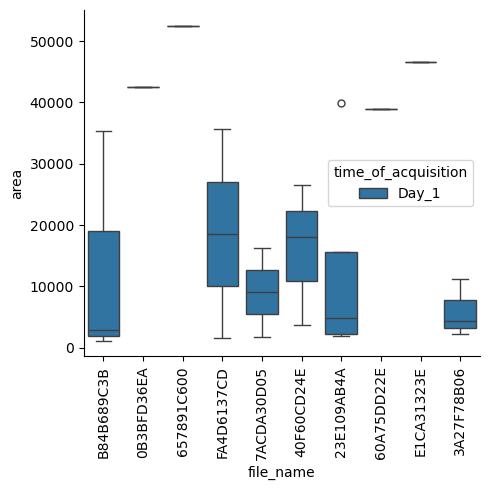

In [9]:
g = sns.catplot(data=master_df, x='file_name', y='area', hue='time_of_acquisition', kind='box', legend_out=False)
plt.draw()
# set rotation
g.set_xticklabels(labels=master_df['file_name'].unique(), rotation=90)
plt.tight_layout()

### Plot circularity boxplots

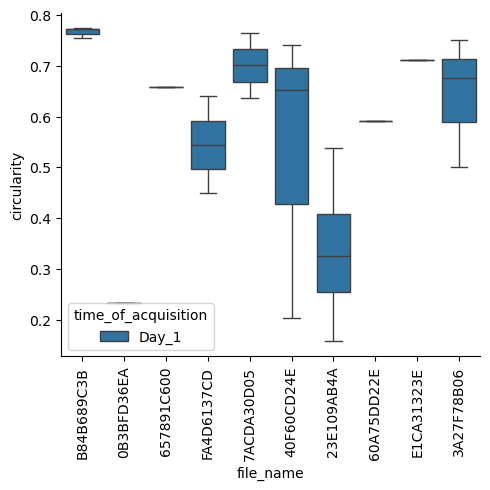

In [10]:
g = sns.catplot(data=master_df, x='file_name', y='circularity', hue='time_of_acquisition', kind='box', legend_out=False)
plt.draw()
# set rotation
g.set_xticklabels(labels=master_df['file_name'].unique(), rotation=90)
plt.tight_layout()

### Plot log of area boxplots

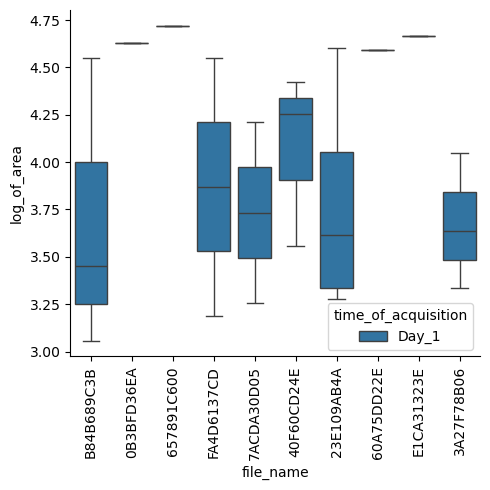

In [11]:
g = sns.catplot(data=master_df, x='file_name', y='log_of_area', hue='time_of_acquisition', kind='box', legend_out=False)
plt.draw()
# set rotation
g.set_xticklabels(labels=master_df['file_name'].unique(), rotation=90)
plt.tight_layout()

### Plot each file in a different plot

Difference between log of areas for each file (before and after in case of multiple days):

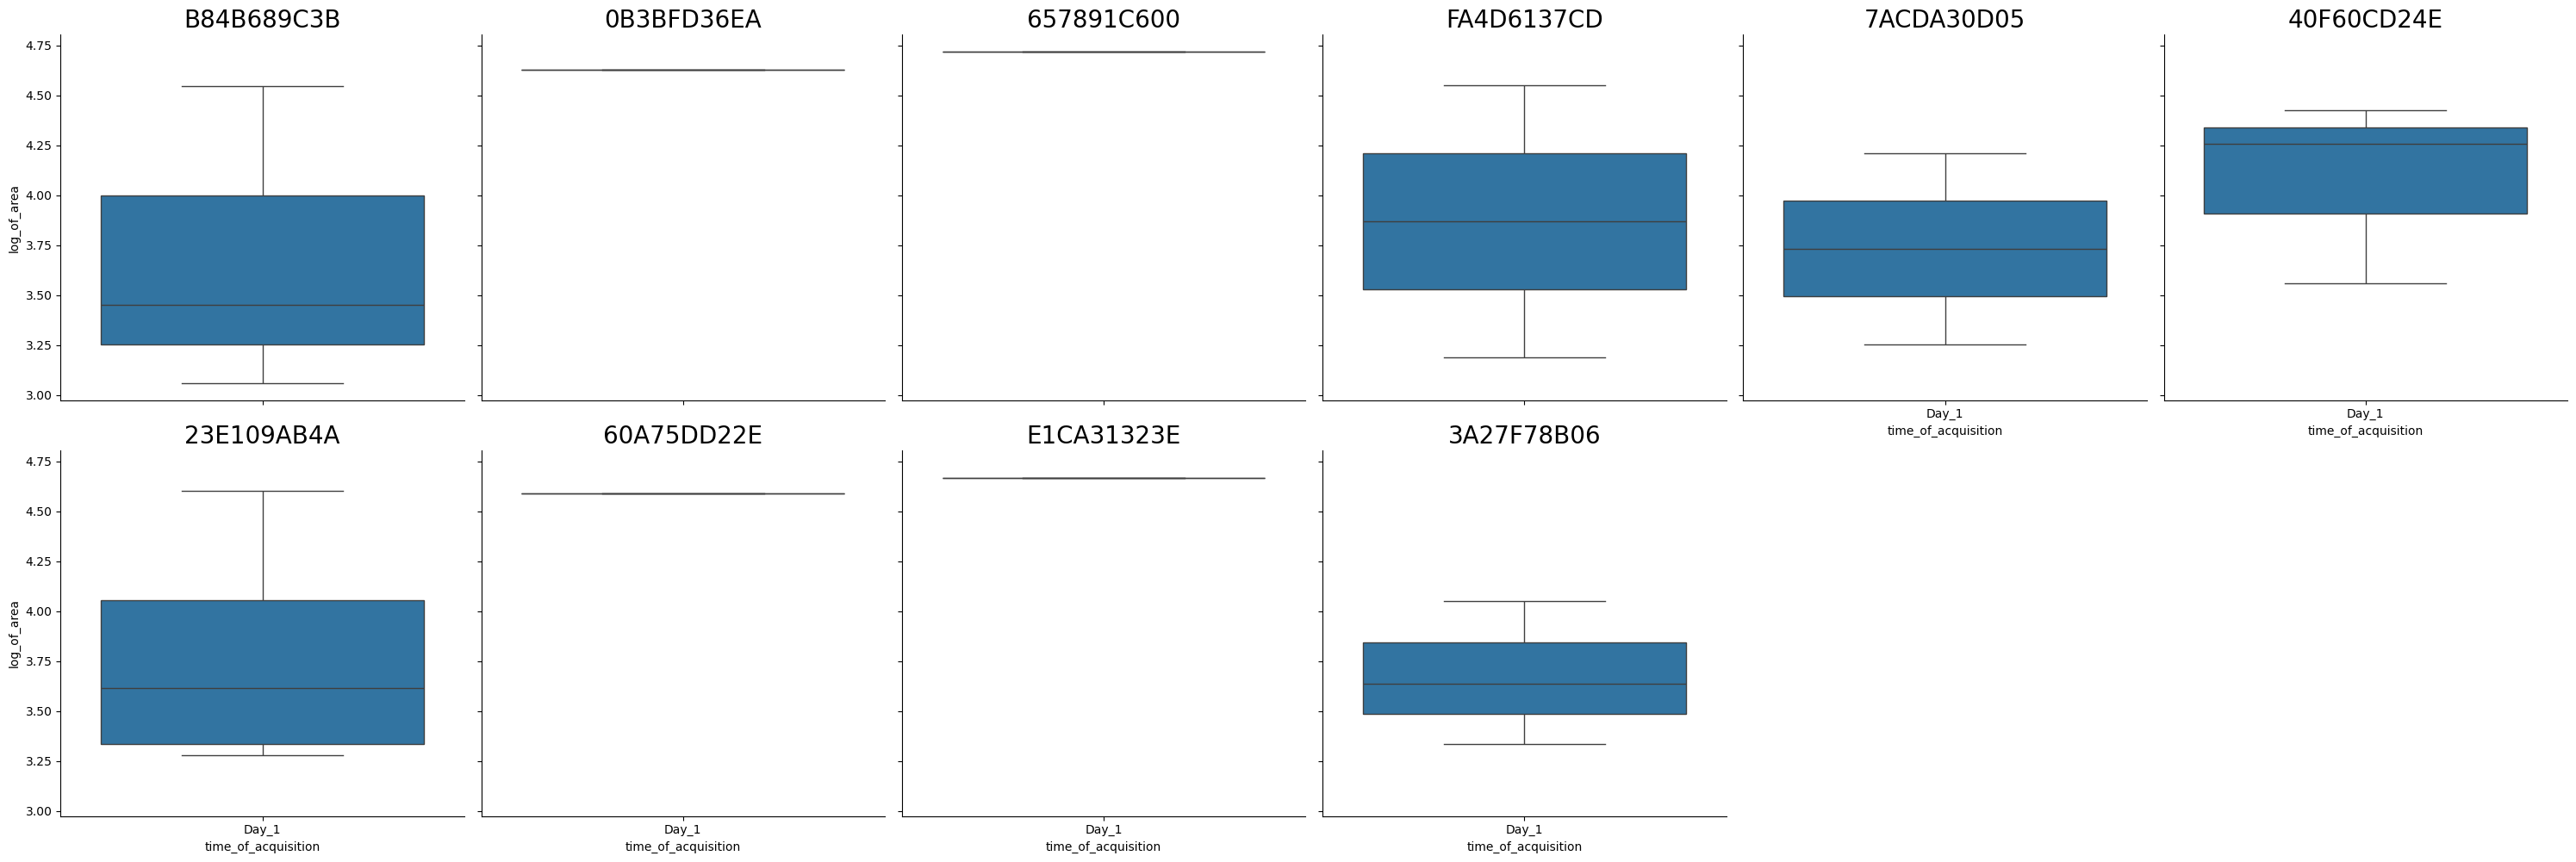

In [12]:
g = sns.catplot(data=master_df,  x='time_of_acquisition', y='log_of_area', hue='time_of_acquisition', col='file_name', col_wrap = 6, kind='box', legend_out=False)
g.set_titles(col_template='{col_name}', size=20)

Difference between circularity for each file (before and after):

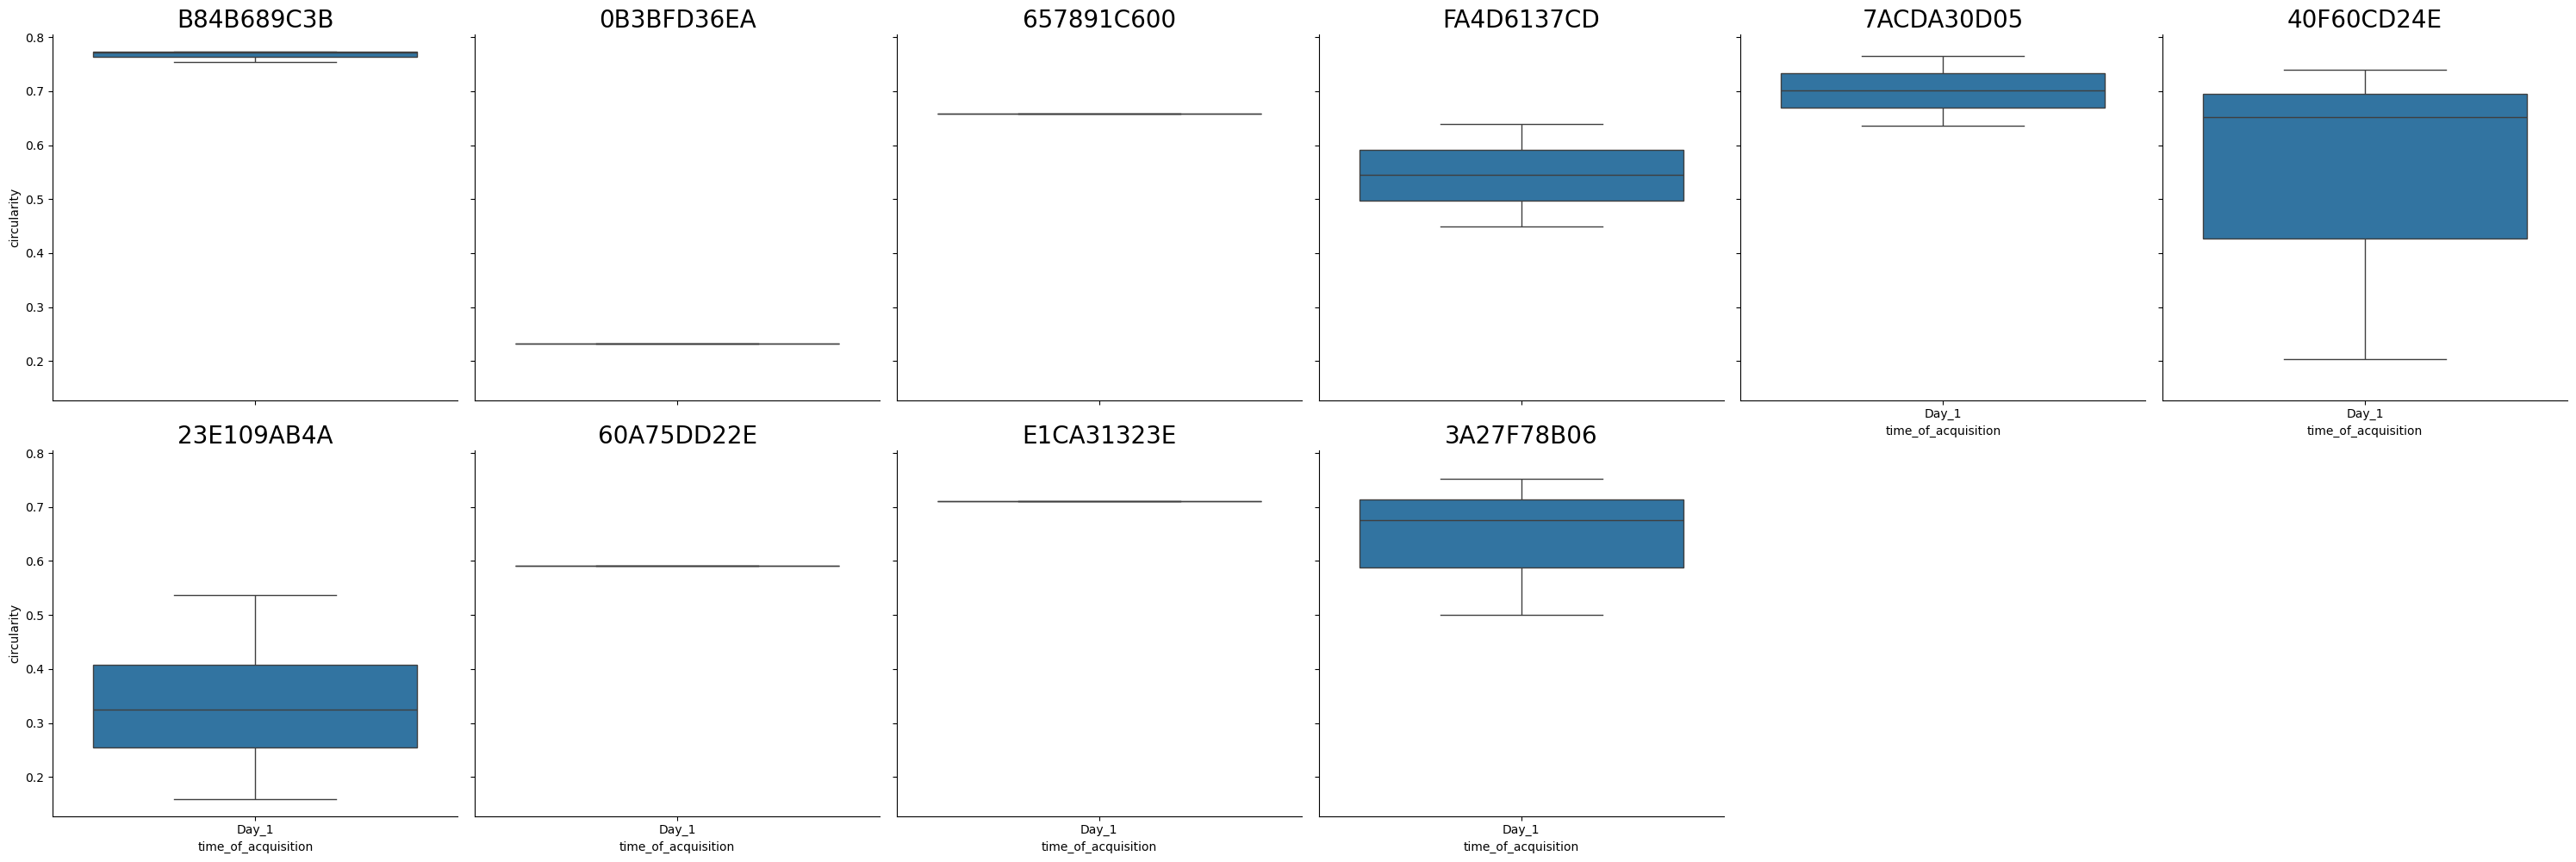

In [13]:
g = sns.catplot(data=master_df,  x='time_of_acquisition', y='circularity', hue='time_of_acquisition', col='file_name', col_wrap = 6, kind='box', legend_out=False)
g.set_titles(col_template='{col_name}', size=20)

## Version Information

In [14]:
%watermark -v -m --gpu -p napari,numpy,pyclesperanto_prototype,pandas,skimage,napari_simpleitk_image_processing,napari_skimage_regionprops,seaborn

Python implementation: CPython
Python version       : 3.13.5
IPython version      : 9.4.0

napari                           : 0.5.0
numpy                            : 2.2.6
pyclesperanto_prototype          : 0.24.4
pandas                           : 2.2.3
skimage                          : 0.25.1
napari_simpleitk_image_processing: 0.4.9
napari_skimage_regionprops       : 0.10.1
seaborn                          : 0.13.2

Compiler    : MSC v.1943 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 16
Architecture: 64bit

GPU Info: 
  GPU 0: NVIDIA GeForce GTX 1650 Ti with Max-Q Design

